In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import matthews_corrcoef

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from data_loader import ImageItemListCell
from augmentation import cutout

In [5]:
from fastai.callbacks.hooks import  params_size
def extract_train_information(learner: Learner):
    #_, params, trainables, _ = params_size(learner.model)

    #total_params = sum(params)
    #trainable_ratio = sum([param*train for param, train in zip(params, trainables)]) / total_params * 100

    bs = learner.data.batch_size
    image_size = learner.data.valid_ds[0][0].size
    wd = learner.wd
    lr = max(learner.recorder.lrs)

    summary = ""
    #summary = "\nTotal params: {:,}".format(total_params)
    #summary += f"\nTrainable: {round(trainable_ratio,2)}%"
    summary += f"\nBs: {bs}"
    summary += f"\nwd: {wd}"
    summary += f"\nlr: {lr}"
    summary += f"\nImage: {image_size}\n"

    for tf in learner.data.train_dl.dl.dataset.tfms:
        summary += f"\n {tf}"
    
    return summary

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [7]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [8]:
len(fnames)

10661

#### Data augmentation

In [9]:
cutout_fn = TfmLighting(cutout)
xtra_tfms=[cutout_fn(n_holes=5, length=0.1)] #squish(scale=0.66)
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      #max_lighting=0.15, 
                      #max_zoom=1.5, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

#### Create dataset 

In [10]:
test_path = Path('/data/Datasets/WhiteBloodCancer/test/')
pat = re.compile(r'^.*(hem|all).bmp$')

def get_data(bs, size):
    
    data  = (ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=tfms, size=size, bs=bs, valid_pct=0.1)
       ).normalize()
    #data = data.normalize((channel_mean, channel_std))
    return data
    

7


epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.506470,0.371903,0.137899,0.850698,0.686546
2,0.364339,0.283168,0.101313,0.893901,0.768297
3,0.305237,0.271605,0.109756,0.883604,0.751639
4,0.264291,0.201119,0.082552,0.914682,0.810797
5,0.234358,0.258301,0.097561,0.897167,0.780325
6,0.215741,0.187141,0.075985,0.921150,0.828212
7,0.199095,0.213690,0.074109,0.923621,0.830636
8,0.177870,0.131864,0.045966,0.953796,0.894150
9,0.163717,0.128033,0.050657,0.949018,0.883221
10,0.160144,0.123705,0.047842,0.951950,0.889882


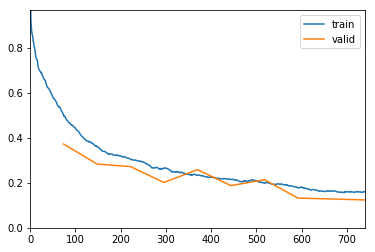

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.166125,0.124239,0.046904,0.952631,0.891932
2,0.165710,0.177930,0.074109,0.926630,0.835676
3,0.164976,0.213709,0.085366,0.911823,0.803767
4,0.163895,0.143997,0.054409,0.944537,0.875407
5,0.150307,0.137264,0.054409,0.945241,0.874526
6,0.139343,0.104937,0.045966,0.953908,0.894384
7,0.128666,0.140660,0.056285,0.944294,0.875850
8,0.114572,0.099464,0.044090,0.955992,0.899571
9,0.107453,0.085663,0.035647,0.964270,0.918154
10,0.107124,0.084768,0.035647,0.964241,0.918089


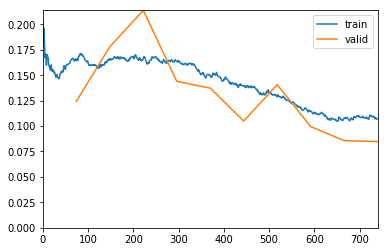

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.105893,0.085153,0.035647,0.964270,0.918154


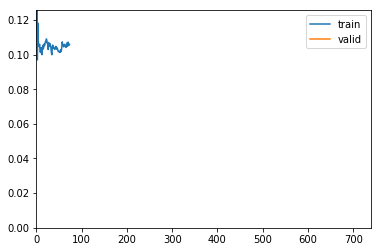

In [ ]:
for fold in range(10):
    #print(fold)
    
    gc.collect()
    experiment_name = 'rn18-Rnd-{}'.format(fold)
    size = 450
    bs = 128 
    
    learn = create_cnn(get_data(bs, size), models.resnet18, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.4, gamma=0.5),
                   #ps=0.75,
                   wd=0.001,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  )
    
    lr = 1e-2
    learn.fit_one_cycle(10, lr)
    
    learn.unfreeze()
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))
    
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage3-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))
    
    preds_test, y_test=learn.get_preds(ds_type=DatasetType.Valid)# 
    preds_test = np.argmax(torch.sigmoid(preds_test), axis=1)
    score = int(matthews_corrcoef(y_test, preds_test) * 10000)
    
    learn.export('{}-{}-{}.pkl'.format(experiment_name, size, score))
    print(fold)